# Introduction

In this notebook, we analyse a sample of multiome PBMC data. Here, we cluster and annotate the cells per modality and inspect how well the two annotation types compare.

## Load packages

In [1]:
import scanpy as sc
import muon as mu
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import matplotlib

import os 

#pretty plotting
import seaborn as sns

# Import a module with ATAC-seq-related functions
from muon import atac as ac

In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.4.0
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.5
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           1.2.0
h5py                3.7.0
hypergeom_ufunc     NA
igraph              0.10.3
invgauss_ufunc      NA
ipykernel           6.20.2
ipython_genutils    0.2.0
ipywidgets          8.0.4
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.1
llvmlite            0.39.1
louvain             0.8.0
matplotlib          3.6.2
mpl_toolkits        NA
mudata              0.2.1
muon                0.1.2
natsort             8.2.0
nbinom_ufunc        NA
ncf_ufunc           NA
nct_ufunc           NA
ncx2_ufunc      

Of note, you can set the context as well to 'talk' or 'paper' in all `seaborn` plots.

In [3]:
sns.set_context(context='paper')

# Set project file paths

We set up the file paths to the respective directories.

In [4]:
file_path = '/home/marenbuettner/data_analysis/muon_tutorial/' 
#this is my file path please adapt it to your directory

File path to the raw data. They are usually stored at a different location than the rest of the project.

In [5]:
data_raw_dir = file_path + 'raw_data/'

The data directory contains all processed data and `mdata` files. 

In [6]:
data_dir = file_path + 'data/' 

The tables directory contains all tabular data output, e.g. in `.csv` or `.xls` file format. That applies to differential expression test results or overview tables such as the number of cells per cell type.

In [7]:
table_dir = file_path + 'tables/'

The resources directory contains any external data input that we use for the project. For instance, gene lists like the cell cycle genes or any manually curated gene list provided by a collaborator can be stored here.

In [8]:
resource_dir = file_path + 'resources/'

The default figure path is a POSIX path calles 'figures'. If you don't change the default figure directory, scanpy creates a subdirectory where this notebook is located.  

In [9]:
sc.settings.figdir = file_path + 'figures/'

**Comment:** When you repeat certain analyses, it might be helpful to set a date variable and add it to every figure and table (see `datetime` Python package).

In [10]:
import datetime

today = datetime.date.today().strftime('%y%m%d') #creates a YYMMDD string of today's date

# Read data

Let us read the normalised data from file. 
`mdata` here is a MuData object that has been created directly from an AnnData object with multiple features types.

In [12]:
mdata = mu.read(os.path.join(data_dir, 'mdata_norm.h5mu'))

In [13]:
mdata

MuData object with n_obs × n_vars = 11784 × 132435
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
  2 modalities
    rna:	11565 x 26349
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'draw_graph', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_draw_graph_fa', 'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'norm'
      obsp:	'connectivities', 'distances'
    atac:	10069 x 106086
      obs:	'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'atac', 'files', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'norm'
      obsp:	'connectivities', 'distances'

# Analysis

In the following, we will analyse the RNA and ATAC modalities separately, annotate cell types, and inspect gene expression and peaks, respectively.

## RNA

In [14]:
rna = mdata.mod['rna']
rna

AnnData object with n_obs × n_vars = 11565 × 26349
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'draw_graph', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm'
    obsp: 'connectivities', 'distances'



### Cell type annotation

Use `leiden` clustering to compute clusters.

In [15]:
sc.tl.leiden(adata = rna, resolution=.5)

running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/marenbuettner/miniconda3/envs/muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


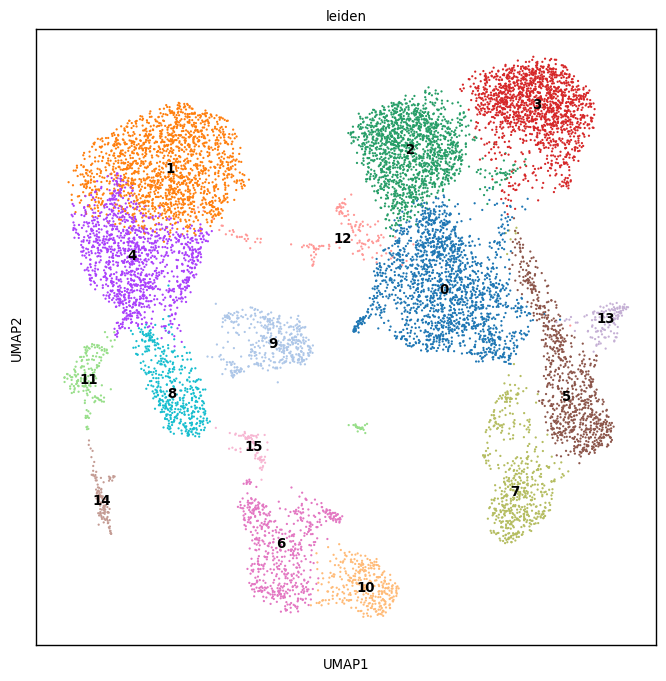

In [16]:
sc.pl.umap(rna, color="leiden", legend_loc="on data")

Compute marker genes per cluster.

In [20]:
# trouble shooting for rank_genes_groups function
del rna.uns['log1p']

In [21]:
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test')

ranking genes


/home/marenbuettner/miniconda3/envs/muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


In [22]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p,14_n,14_p,15_n,15_p
0,INPP4B,0.000000e+00,VCAN,0.0,LEF1,0.000000e+00,LEF1,0.000000e+00,SLC8A1,0.0,CCL5,0.000000e+00,BANK1,0.000000e+00,GNLY,0.000000e+00,TCF7L2,0.000000e+00,NEAT1,1.526677e-212,IGHM,1.717855e-288,CD74,1.059773e-91,RPS29,5.846133e-17,SLC4A10,3.747583e-58,TCF4,2.131756e-108,BANK1,3.763629e-47
1,IL32,0.000000e+00,PLXDC2,0.0,BCL11B,0.000000e+00,BACH2,0.000000e+00,AOAH,0.0,NKG7,2.971205e-269,CD74,0.000000e+00,NKG7,1.322670e-278,PSAP,0.000000e+00,PLXDC2,7.321108e-183,AFF3,7.544224e-270,HLA-DPB1,1.934433e-82,RPS12,4.711167e-16,NKG7,5.864130e-48,RHEX,9.108126e-85,AFF3,3.540143e-43
2,LTB,0.000000e+00,DPYD,0.0,BACH2,0.000000e+00,PDE3B,0.000000e+00,PLXDC2,0.0,IL32,1.891504e-273,RALGPS2,2.564339e-316,CD247,1.510315e-282,LYN,0.000000e+00,ZEB2,1.865029e-167,BANK1,4.769292e-241,HLA-DRA,1.006746e-80,RPS27,5.716091e-15,PHACTR2,7.827507e-47,IRF8,2.498890e-83,CD74,4.056830e-40
3,SYNE2,0.000000e+00,ARHGAP26,0.0,FHIT,0.000000e+00,THEMIS,0.000000e+00,TYMP,0.0,SYNE2,4.783866e-208,AFF3,1.996286e-313,PRF1,5.082503e-224,SAT1,0.000000e+00,LYST,1.426765e-153,CD74,1.556836e-232,HLA-DRB1,1.105081e-77,RPS14,1.143721e-13,RORA,8.299834e-44,FCHSD2,1.102108e-83,MARCH1,3.041277e-38
4,ANK3,0.000000e+00,LRMDA,0.0,CAMK4,0.000000e+00,NELL2,0.000000e+00,NEAT1,0.0,PRKCH,1.044819e-198,MS4A1,1.361492e-278,KLRD1,2.917563e-175,MTSS1,6.945638e-299,DPYD,4.025733e-157,FCRL1,6.639301e-170,HLA-DPA1,1.826535e-75,RPL13,2.993998e-13,SYNE2,6.569065e-42,UGCG,2.849743e-78,LYN,1.349817e-37
5,CDC14A,0.000000e+00,NEAT1,0.0,MALAT1,0.000000e+00,BCL11B,0.000000e+00,DPYD,0.0,GZMA,8.945172e-172,OSBPL10,8.911805e-228,GZMA,3.913496e-171,CST3,1.766513e-289,SLC8A1,3.984406e-142,RALGPS2,3.628712e-166,GAPDH,1.081344e-73,RPL30,8.805332e-12,IL7R,1.244422e-37,AFF3,3.814393e-81,HLA-DRA,1.141581e-35
6,IL7R,0.000000e+00,FCN1,0.0,RPS27A,0.000000e+00,CAMK4,0.000000e+00,JAK2,0.0,SKAP1,2.586453e-180,HLA-DRA,6.100711e-255,SYNE1,4.917200e-165,WARS,6.182361e-282,TYMP,2.598798e-146,HLA-DRA,5.218856e-177,AFF3,1.096592e-72,RPL32,3.015811e-10,SKAP1,6.381030e-37,CD74,5.871123e-85,PLXDC2,9.282735e-33
7,ITGB1,2.698994e-315,ZEB2,0.0,TCF7,1.431978e-283,CD8B,7.416913e-320,FCN1,0.0,A2M,2.525649e-162,CD79A,1.017944e-225,PRKCH,8.991935e-170,CTSS,5.129173e-313,LYN,3.694952e-144,BACH2,8.734853e-164,CST3,2.375321e-71,RPS21,3.503712e-10,A2M,7.265225e-36,PLD4,6.527510e-73,MEF2C,5.807973e-31
8,ARHGAP15,0.000000e+00,CSF3R,0.0,RPS27,3.418694e-305,OXNAD1,0.000000e+00,ZEB2,0.0,SYNE1,1.795888e-160,PAX5,4.409112e-221,CTSW,7.274808e-158,COTL1,5.614806e-275,FCN1,8.384908e-136,PAX5,3.466906e-149,CCDC88A,5.039486e-71,RPS26,1.133104e-09,CCL5,2.003144e-35,BCL11A,1.199665e-67,MS4A1,2.406744e-30
9,BCL11B,0.000000e+00,RBM47,0.0,RPL3,3.560947e-300,TXK,2.503770e-317,DENND1A,0.0,HLA-B,5.446951e-166,BLK,1.280612e-195,MCTP2,1.457131e-153,TYMP,1.373791e-293,AOAH,3.089979e-142,MS4A1,3.121561e-133,HLA-DRB5,9.017724e-69,RPL27A,5.494634e-09,KLRB1,5.005486e-35,RABGAP1L,1.325878e-70,PRKCB,5.573920e-30


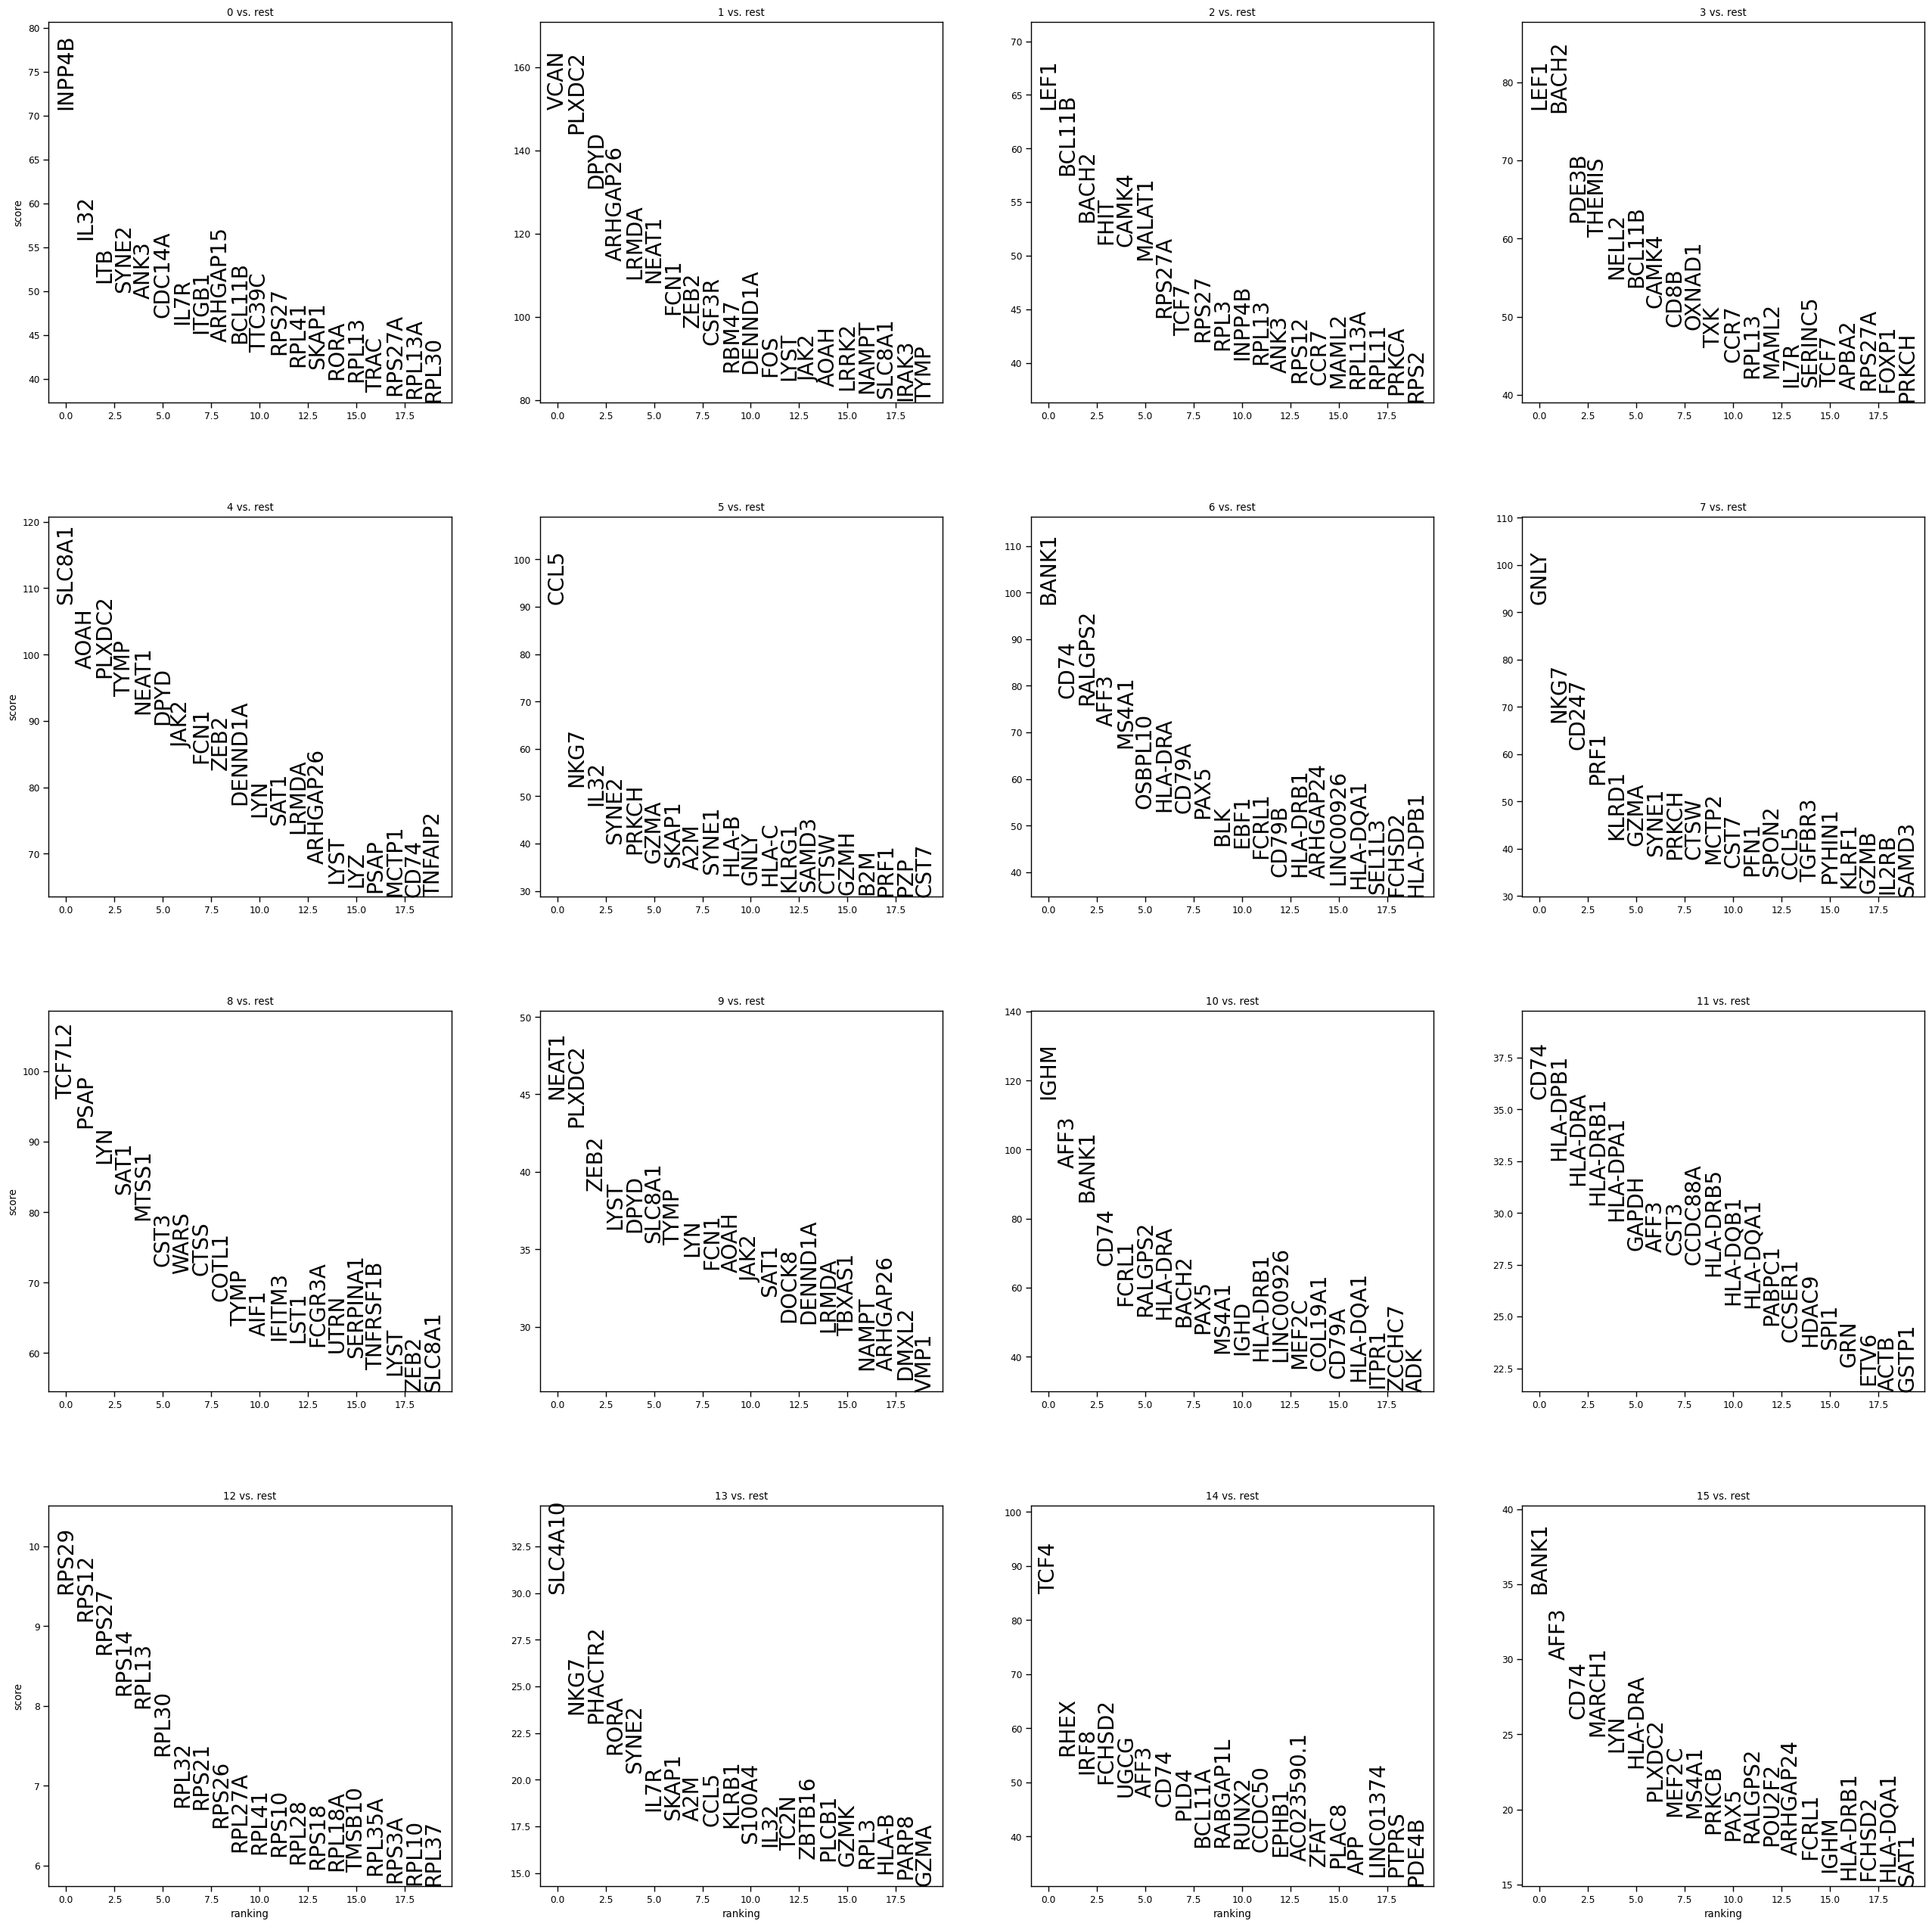

In [28]:
sc.pl.rank_genes_groups(rna, n_genes=20, sharey=False, fontsize=20)

Exploring the data we notice clusters 9 and 15 seem to be composed of cells bearing markers for different cell lineages so likely to be noise (e.g. doublets). Cluster 12 has higher ribosomal gene expression when compared to other clusters.

We will remove cells from these clusters before assigning cell types names to clusters.

In [29]:
mu.pp.filter_obs(rna, "leiden", lambda x: ~x.isin(["9", "15", "12"]))
# Analogous to
#   rna = rna[~rna.obs.leiden.isin(["9", "15", "12", "16"])]
# but doesn't copy the object

In [30]:
new_cluster_names = {
    "0": "CD4+ memory T", 
    "1": "CD14 mono",  
    "2": "CD4+ naïve T",
    "3": "CD8+ naïve T",
    "4": "intermediate mono", 
    "5": "CD8+ activated T", 
    "7": "NK", 
    "13": "MAIT",
    "6": "memory B", 
    "10": "naïve B",
    "8": "CD16 mono",
    "11": "mDC", 
    "14": "pDC",
}

Assign cell type labels to clusters.

In [31]:
rna.obs['celltype'] = rna.obs.leiden.astype("str").values
rna.obs.celltype = rna.obs.celltype.astype("category")
rna.obs.celltype = rna.obs.celltype.cat.rename_categories(new_cluster_names)


We will also re-order categories for the next plots:

In [32]:
rna.obs.celltype.cat.reorder_categories([
    'CD4+ naïve T', 'CD4+ memory T', 'MAIT',
    'CD8+ naïve T', 'CD8+ activated T', 'NK',
    'naïve B', 'memory B',
    'CD14 mono', 'intermediate mono', 'CD16 mono',
    'mDC', 'pDC'], inplace=True)

Define a custom palette.

In [41]:
cmap = plt.get_cmap('tab20b')
colors = cmap(np.linspace(0, 1, len(rna.obs.celltype.cat.categories)))

rna.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

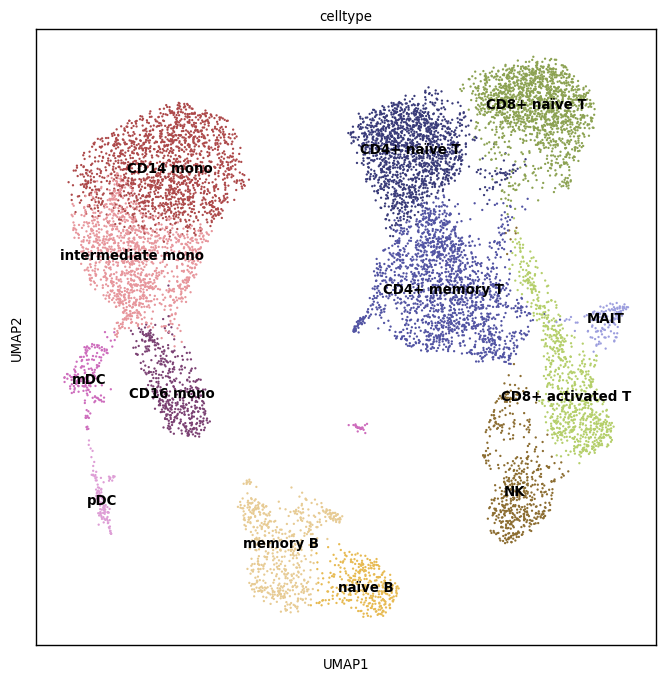

In [43]:
sc.pl.umap(rna, color="celltype", legend_loc="on data")

Finally, we’ll visualise some marker genes across cell types.

In [44]:
marker_genes = ['IL7R', 'TRAC',
                'ITGB1', # CD29
                'SLC4A10',
                'CD8A', 'CD8B', 'CCL5',
                'GNLY', 'NKG7',
                'CD79A', 'MS4A1', 'IGHM', 'IGHD',
                'IL4R', 'TCL1A',
                'KLF4', 'LYZ', 'S100A8', 'ITGAM', # CD11b
                'CD14', 'FCGR3A', 'MS4A7',
                'CST3', 'CLEC10A', 'IRF8', 'TCF4']

/home/marenbuettner/miniconda3/envs/muon/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


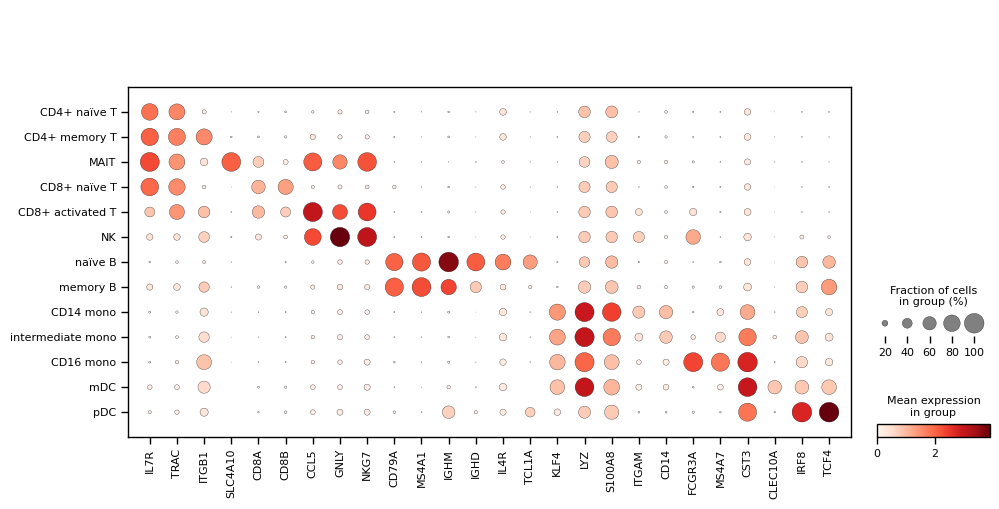

In [47]:
sc.pl.dotplot(rna, marker_genes, groupby='celltype', use_raw = False, layer='norm')

## ATAC

In [48]:
atac = mdata.mod['atac']
atac

AnnData object with n_obs × n_vars = 10069 × 106086
    obs: 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'atac', 'files', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm'
    obsp: 'connectivities', 'distances'

### Cell type annotation

To stay comparable to the gene expression notebook, we will use leiden to cluster cells.


In [49]:
sc.tl.leiden(atac, resolution=.5)

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/marenbuettner/miniconda3/envs/muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


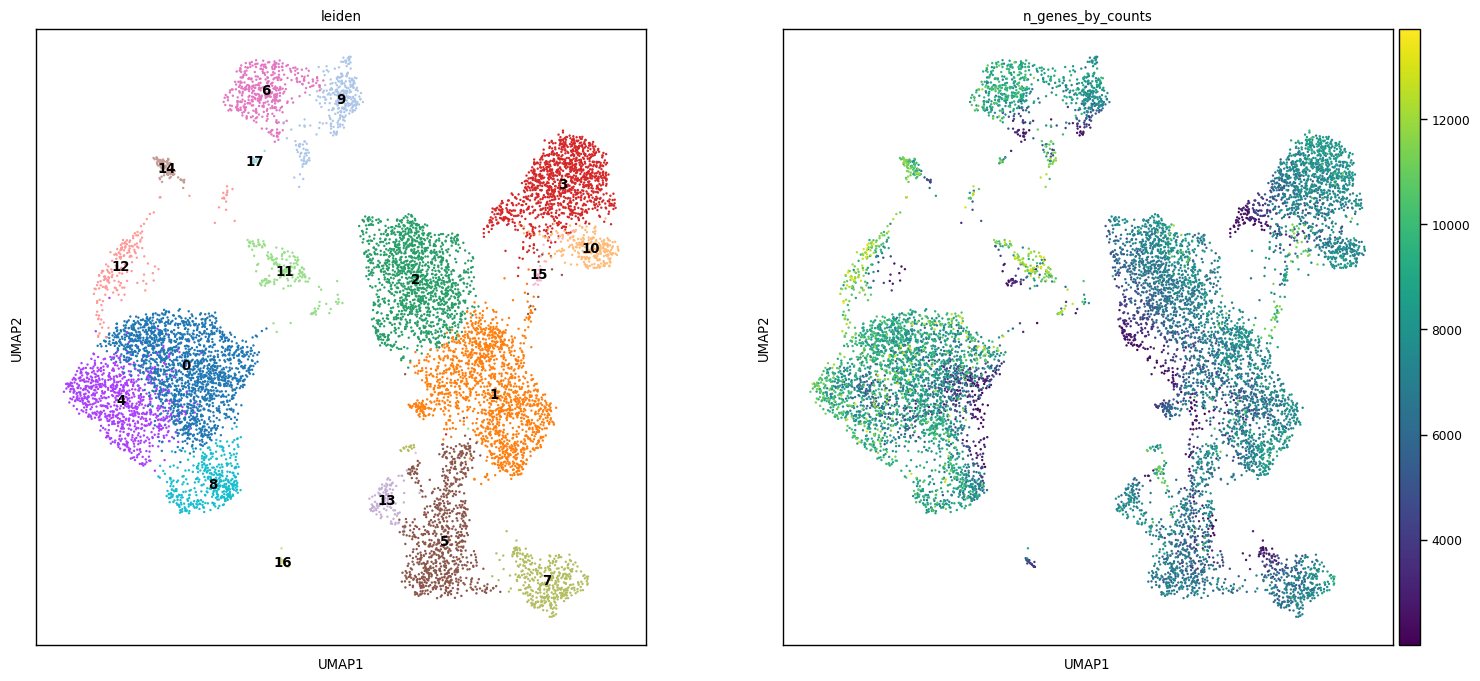

In [50]:
sc.pl.umap(atac, color=["leiden", "n_genes_by_counts"], legend_loc="on data")

Again, we can use the functionality of the ATAC module in `muon` to color plots by cut values in peaks correspoonding to a certain gene:

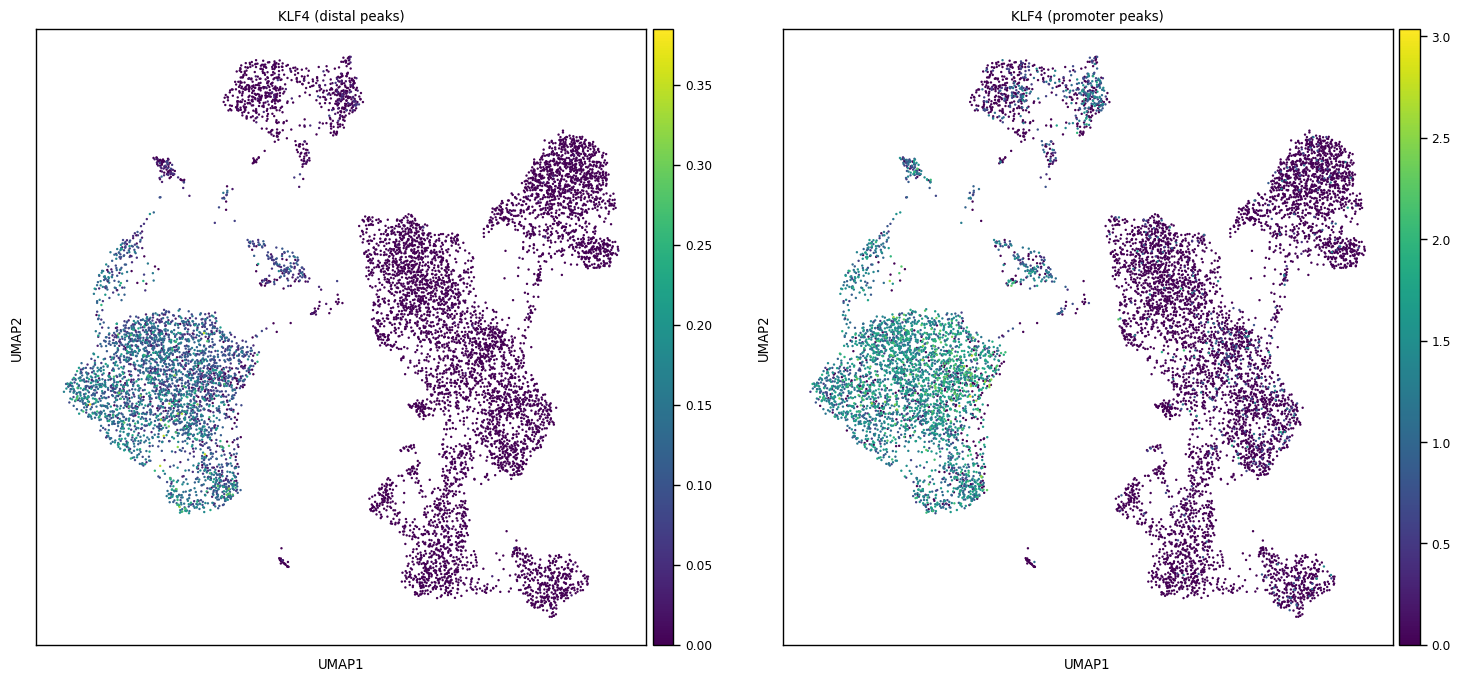

In [53]:
ac.pl.umap(atac, color=["KLF4"], average="peak_type", use_raw=False, layer='norm')

We will now define cell types based on chromatin accessibility.

In [55]:
# trouble shooting for rank peaks groups function below
del atac.uns['log1p']

In [56]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')

ranking genes


/home/marenbuettner/miniconda3/envs/muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:41)


In [63]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option("max_columns", 50)
res_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'genes', 'pvals']}).head(10)

In [77]:
res_df.iloc[:, 24:]

,8_n,8_g,8_p,9_n,9_g,9_p,10_n,10_g,10_p,11_n,11_g,11_p,12_n,12_g,12_p,13_n,13_g,13_p,14_n,14_g,14_p,15_n,15_g,15_p,16_n,16_g,16_p,17_n,17_g,17_p
0,chr19:18167172-18177541,"PIK3R2, IFI30",2.116674e-86,chr22:41931503-41942227,CENPM,6.138052e-99,chr2:86783559-86792275,CD8A,1.128930e-58,chr9:107480158-107492721,KLF4,2.605999e-09,chr9:107480158-107492721,KLF4,1.393987e-42,chr11:114072228-114076352,ZBTB16,7.670707e-23,chr17:81425658-81431769,BAHCC1,8.694027e-34,chr16:88448143-88480965,ZFPM1,2.133287e-12,chr10:133265906-133281093,"TUBGCP2, ADAM8",4.538235e-08,chr22:22926399-22936461,IGLC7,2.602091e-08
1,chr9:134369462-134387253,RXRA,3.764327e-79,chr22:41917087-41929835,TNFRSF13C,1.970016e-94,chr14:99255246-99275454,"BCL11B, AL109767.1",5.556857e-59,chr2:218361880-218373051,"CATIP, CATIP-AS1",3.365514e-08,chr3:4975862-4990757,"BHLHE40, BHLHE40-AS1",2.351271e-38,chr22:44709028-44711972,PRR5,1.230699e-22,chr17:3910107-3919628,P2RX1,1.222269e-29,chr14:101807949-101830976,"PPP2R5C, AL137779.2",1.364486e-08,chr19:21593423-21595308,AC123912.2,1.443595e-07,chr10:110353286-110359160,SMNDC1,5.102887e-07
2,chr5:1476663-1483241,"SLC6A3, LPCAT1",1.032226e-75,chr5:150385442-150415310,"CD74, TCOF1",7.119427e-92,chr14:99223600-99254668,"BCL11B, AL109767.1",8.698419e-59,chr9:134369462-134387253,RXRA,1.546835e-07,chr5:150385442-150415310,"CD74, TCOF1",3.648692e-37,chr16:81519063-81525049,CMIP,1.534262e-22,chr12:108627138-108639115,"SELPLG, AC007569.1",5.350309e-28,chr5:35850992-35860227,IL7R,1.421720e-08,chr17:82211956-82220400,"CCDC57, AC132872.2",4.006488e-06,chr1:117653309-117657455,TENT5C,1.223868e-06
3,chr20:40686526-40691350,MAFB,1.506519e-74,chr19:5125450-5140568,"KDM4B, AC022517.1",5.996938e-89,chr14:99181080-99219442,"BCL11B, AL162151.1",8.306654e-55,chr11:1777309-1784076,AC068580.2,4.520316e-07,chr1:220876295-220883526,"HLX, HLX-AS1",2.673774e-36,chr15:39623205-39625650,"FSIP1, AC037198.2",1.149144e-21,chr22:50281096-50284890,PLXNB2,3.843163e-27,chr5:134110288-134135061,TCF7,1.117150e-07,chr17:75771404-75787641,"H3F3B, UNK",4.607565e-06,chr2:181303834-181310073,LINC01934,4.285367e-06
4,chr2:16653069-16660704,FAM49A,1.133945e-72,chr2:231669797-231676530,PTMA,5.604027e-75,chr5:134110288-134135061,TCF7,2.159204e-48,chr20:50269694-50277398,SMIM25,6.474395e-07,chr18:9707302-9713342,RAB31,5.674833e-29,chr20:35250675-35252861,MMP24,3.708803e-21,chr6:11730442-11733107,"ADTRP, AL022724.3",8.037821e-27,chr19:16363226-16378669,"EPS15L1, AC020917.3",6.283951e-07,chr9:91419015-91426704,"NFIL3, AL353764.1",6.142868e-06,chr20:47414623-47417478,LINC01754,6.489840e-06
5,chr18:13562096-13569511,"LDLRAD4, AP005131.3",2.870043e-71,chr6:150598919-150601318,AL450344.3,2.098927e-73,chr1:24500773-24509089,"RCAN3, RCAN3AS",5.910735e-45,chr3:93470156-93470998,,8.326372e-07,chr17:81044486-81052618,BAIAP2,9.581590e-29,chr11:114065160-114066911,ZBTB16,7.367467e-21,chr17:16986865-16990016,LINC02090,2.373697e-26,chr22:39087900-39092994,APOBEC3H,1.207371e-06,chr6:146543038-146547054,RAB32,6.715263e-06,chr19:16116910-16120475,RAB8A,1.125913e-05
6,chr9:107480158-107492721,KLF4,4.668545e-70,chr6:167111604-167115345,"CCR6, AL121935.1",2.522864e-73,chr17:78107894-78136274,"TNRC6C, TMC6, TMC8, TNRC6C-AS1",4.800975e-43,chr1:182143071-182150314,"LINC01344, AL390856.1",1.701380e-06,chr2:47067863-47077814,"TTC7A, AC073283.1",4.455531e-28,chr20:33369063-33370940,CDK5RAP1,7.074061e-21,chr20:43681305-43682881,MYBL2,2.832020e-26,chr16:85609841-85617514,GSE1,1.210675e-06,chr21:34907551-34910714,RUNX1,8.304409e-06,chr11:102473481-102475121,AP001830.2,1.142937e-05
7,chr8:55878674-55886699,LYN,4.104578e-69,chr1:30737200-30766455,LAPTM5,5.758151e-73,chr22:37218096-37232892,"RAC2, SSTR3",3.128848e-42,chr15:51619103-51624336,DMXL2,4.961269e-06,chr10:128045032-128071717,PTPRE,3.913494e-28,chr17:40536232-40543738,CCR7,7.310864e-21,chr19:50414004-50420358,"POLD1, SPIB",1.255744e-25,chr20:63733192-63743479,"SLC2A4RG, ZGPAT, LIME1",1.598500e-06,chr17:8068680-8069932,AC129492.1,1.317718e-05,chr16:81

Having studied markers of individual clusters, we will filter some cells out before assigning cell types names to clusters: likely doublets in clusters 11 and 15, proliferating cells in 16, stressed cells in 17.

In [78]:
mu.pp.filter_obs(atac, "leiden", lambda x: ~x.isin(["11","15", "16", "17"]))
# Analogous to
#   atac = atac[~atac.obs.leiden.isin(["15", "16", "17"])]
# but doesn't copy the object

In [79]:
new_cluster_names = {
    "1": "CD4+ memory T", #
    "2": "CD4+ naïve T", #
    "3": "CD8+ naïve T", #

    "5": "CD8+ activated T", #
    "8": "CD16 mono", #
    "12": "mDC", # 

    "9": "naïve B", #
    "6": "memory B",#
    "0": "intermediate mono", #
    "4": "CD14 mono", #
    "7": "NK", #
    
    "13": "MAIT",#
    "10": "CD4+ naïve T", #
    "14": "pDC",
}



In [82]:

atac.obs['celltype'] = atac.obs.leiden.astype("str").values
atac.obs.celltype = atac.obs.celltype.map(new_cluster_names).astype("category")

We will also re-order categories for the next plots:


In [84]:
atac.obs.celltype.cat.reorder_categories([
    'CD4+ naïve T', 'CD4+ memory T', 'MAIT',
    'CD8+ naïve T', 'CD8+ activated T', 'NK',
    'naïve B', 'memory B',
    'CD14 mono', 'intermediate mono', 'CD16 mono',
    'mDC', 'pDC'], inplace=True)

Define a custom palette.

In [85]:
cmap = plt.get_cmap('tab20b')
colors = cmap(np.linspace(0, 1, len(rna.obs.celltype.cat.categories)))

atac.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

/home/marenbuettner/miniconda3/envs/muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


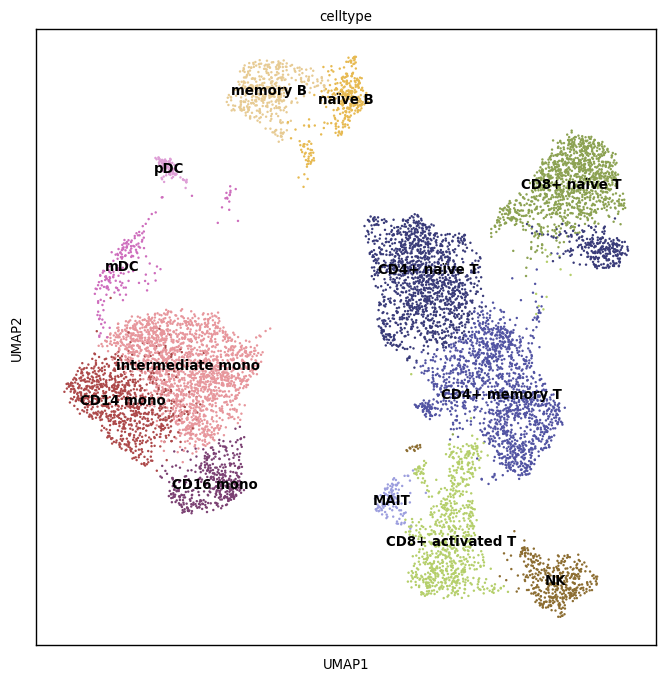

In [86]:
sc.pl.umap(atac, color="celltype", legend_loc="on data")

Finally, we visualise some marker genes across cell types.


In [87]:
marker_genes = ['IL7R', 'TRAC',
                'GATA3',
                'SLC4A10',
                'CD8A', 'CD8B', 'CD248', 'CCL5',
                'GNLY', 'NKG7',
                'CD79A', 'MS4A1', 'IGHD', 'IGHM', 'TNFRSF13C',
                'IL4R', 'KLF4', 'LYZ', 'S100A8', 'ITGAM', 'CD14',
                'FCGR3A', 'MS4A7', 'CST3',
                'CLEC10A', 'IRF8', 'TCF4']

/home/marenbuettner/miniconda3/envs/muon/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


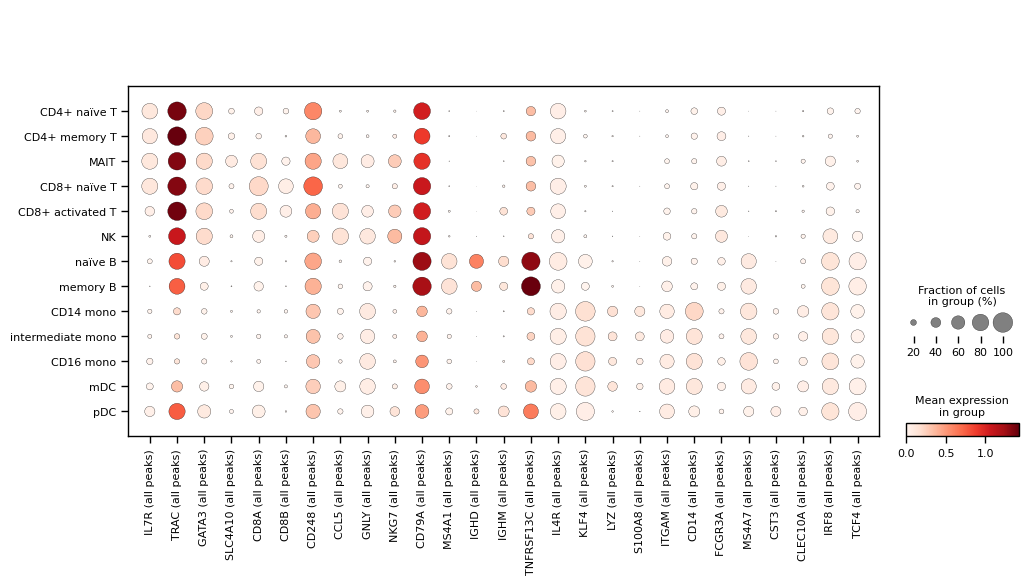

In [90]:
ac.pl.dotplot(atac, marker_genes, groupby='celltype', use_raw=False, layer='norm')

In [12]:
marker_peaks = [
    'chr14:99255246-99275454', 'chr10:33135632-33141841',                              # T/NK
    'chr1:1210271-1220028',                                                            # memory T/NK
    'chr2:86783559-86792275',                                                          # CD8+ T/NK
    'chr12:10552886-10555668',                                                         # naïve CD8+ T
    'chr11:114072228-114076352',                                                       # MAIT/NK
    'chr5:150385442-150415310',                                                        # B and mono (CD74)
    'chr22:41931503-41942227', 'chr22:41917087-41929835', 'chr6:167111604-167115345',  # B
    'chr9:107480158-107492721', 'chr5:1476663-1483241',                                # mono
    'chr10:75399596-75404660', 'chr1:220876295-220883526',                             # mDC
    'chr17:81425658-81431769', 'chr7:98641522-98642532',                               # pDC
]

/home/marenbuettner/miniconda3/envs/muon/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


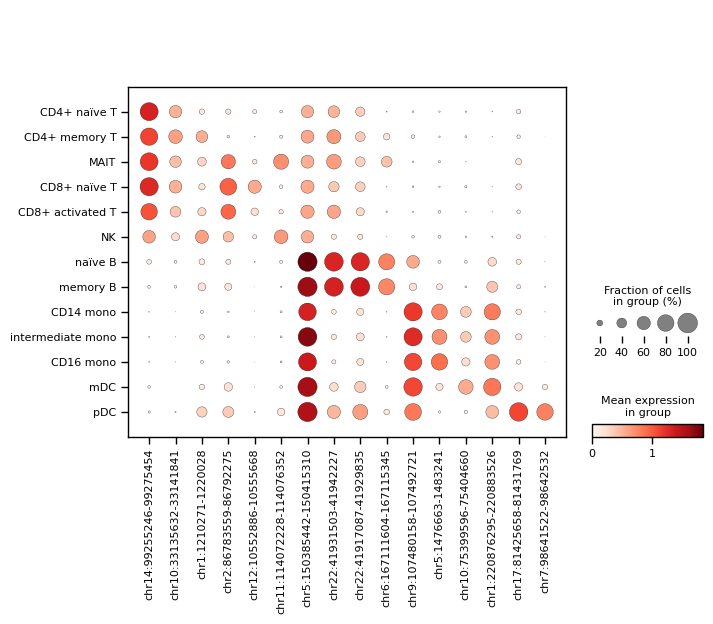

In [13]:
sc.pl.dotplot(mdata['atac'], marker_peaks, 'celltype', use_raw=False, layer='norm')

## Compare annotation

In [92]:
mdata2 = mdata.copy()

In each modality, only cells passing respective QC are retained. For the cell type comparison, we will use only cells that are present for both modalities:



In [93]:
mu.pp.intersect_obs(mdata2)

In [94]:
mdata2.shape

(9529, 132435)

Let us check how well those cell type annotations match per cell type:

In [96]:
# Calculate total number of cells of respective ATAC celltypes
df_total = (
    mdata2.obs.groupby("atac:celltype").
        size().
        reset_index(name="n_total").
        set_index("atac:celltype")
)

# Calculate number of cells for each pair of RNA-ATAC celltype annotation
df = (
    mdata2.obs.groupby(["atac:celltype", "rna:celltype"]).
        size().
        reset_index(name="n").
        set_index("atac:celltype").
        join(df_total).
        reset_index()
)

# Calculate a fraction of cells of each RNA celltype (n)
# for each ATAC celltype (/ n_total)
df_frac = df.assign(frac = lambda x: x.n / x.n_total)

We can now make a wide table and visualise it with a heatmap.

In [97]:
df_wide = df_frac.set_index("atac:celltype").pivot(columns="rna:celltype", values="frac")

<AxesSubplot: xlabel='rna:celltype', ylabel='atac:celltype'>

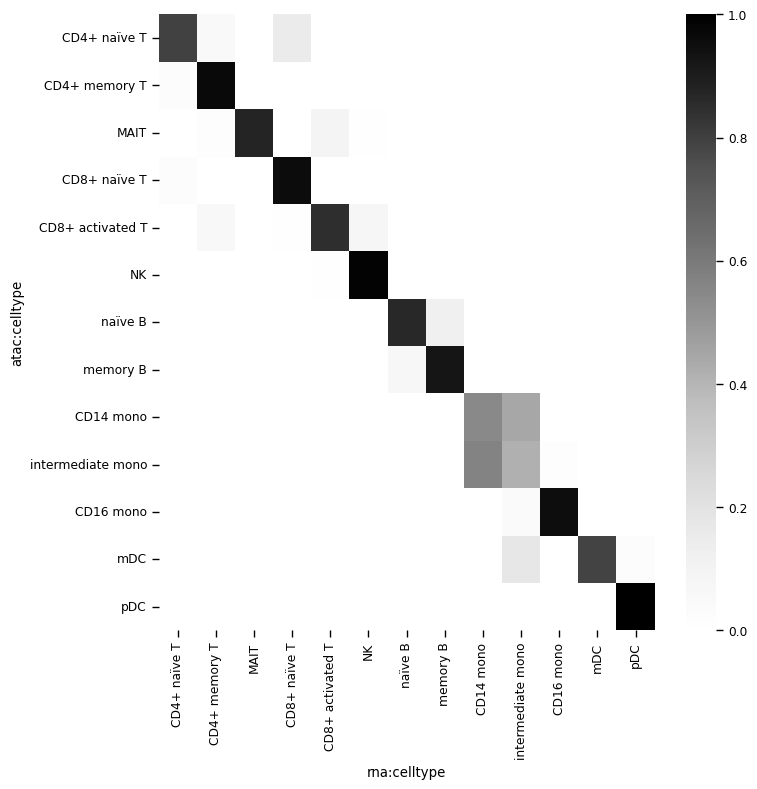

In [98]:
sns.heatmap(df_wide, cmap="Greys")

It seems that cell types are highly reproducible across modalities with the only exception of the CD14/intermediate monocytes annotation that doesn’t seem particularly confident — most probably in the ATAC modality. 

# Save to file

In [91]:
mdata.write(data_dir + 'mdata_annotated.h5mu')

/home/marenbuettner/miniconda3/envs/muon/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
